In [16]:
# A spam classifier will classify all messages you receive. There will be 4 possibilities :

#     correct classification :
#         True positives : true spams which will be classified as true spams;
#         True negatives : true legitimate messages which will be classified as legitimate messages.

#     wrong classification :
#         False negatives : true spam which will be classified as being legitimate messages;
#         False positives : legitimate messages which will be classified as being spams.

# That said, a good classifier will minimize the two “False” categories. But, either way, 
# it’s better to receive some false negative errors (spam being put in your inbox) 
# than some false positives (legitimate messages being lost).

# All this is controlled at some place by some sort of threshold. So, IMHO, a good classifier should:

#     minimize errors, both false negatives and false positives;
#     as much as possible, eliminate false positives : don’t loose legitimate messages.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [18]:
sms = pd.read_csv('spam-data.csv',encoding='latin-1')
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [19]:
# PART 1 - exploratory data analysis

# Things we can see:
# - what precentage of our data is spam/ham
# - the top spam/ham messages



In [20]:
# Ok, first, we do not need three columns; also we have to rename some of the other columns for clarity
sms.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
sms.rename(columns = {'v1':'label','v2':'message'}, inplace=True)

In [21]:
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [22]:
# see info and check that everything is OK
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label      5572 non-null object
message    5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


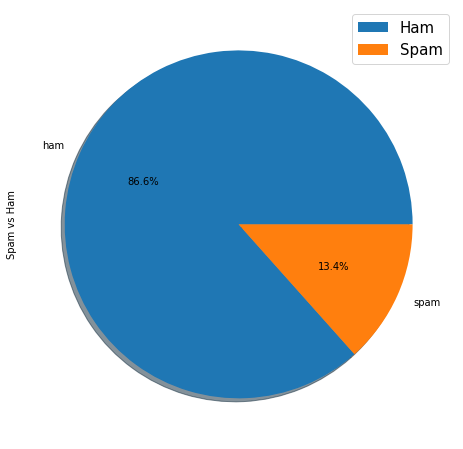

In [23]:
# let's see visually how much are 'ham' and how much are 'spam'
sms['label'].value_counts().plot(kind = 'pie', figsize = (8, 8), shadow = True, autopct = '%1.1f%%')
plt.rcParams.update({'font.size': 15})
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

In [24]:
# OK, it is clear that we have to be careful how we split our data into train/test, because
# otherwise we have a chance of our training model being skewed towards normal messages.

# As we said, we don't mind if we miss the odd spam message but we surely don't want
# to mark a ham message as spam => Precision is very important. 
# Hence we will use fbeta score as our accuracy metric with inclination towards Precision

In [25]:
# Add numerical label for spam, because classification models require that.
sms['spam'] = sms['label'].map( {'spam': 1, 'ham': 0} ).astype(int)
sms.head()

,label,message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [26]:
# let's see the top spam/ham messages
topMessages = sms.groupby("message")["label"].agg([len, np.max]).sort_values(by = "len", ascending = False).head(10)
display(topMessages)

,len,amax
message,,
"Sorry, I'll call later",30,ham
I cant pick the phone right now. Pls send a message,12,ham
Ok...,10,ham
Your opinion about me? 1. Over 2. Jada 3. Kusruthi 4. Lovable 5. Silent 6. Spl character 7. Not matured 8. Stylish 9. Simple Pls reply..,4,ham
"Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da.",4,ham
Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed å£1000 cash or å£5000 prize!,4,spam
Okie,4,ham
"Say this slowly.? GOD,I LOVE YOU &amp; I NEED YOU,CLEAN MY HEART WITH YOUR BLOOD.Send this to Ten special people &amp; u c miracle tomorrow, do it,pls,pls do it...",4,ham
"7 wonders in My WORLD 7th You 6th Ur style 5th Ur smile 4th Ur Personality 3rd Ur Nature 2nd Ur SMS and 1st \Ur Lovely Friendship\""... good morning dear""",4,ham


In [27]:
# Let's add a new feature - length of message.
# It will be interesting to see if there is a correlation between the length
# of the message and whether it is makred as spam or not
sms["length"] = sms["message"].apply(len)
sms["length"].head()

0    111
1     29
2    155
3     49
4     61
Name: length, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f982711fef0>,
      dtype=object)

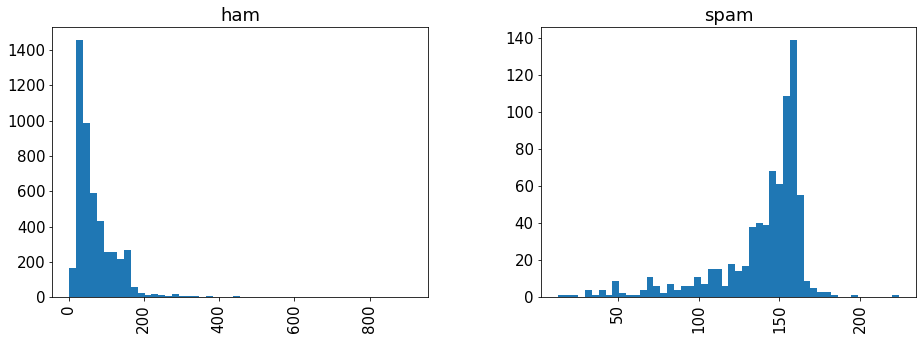

In [28]:
# Ok, let's see that graphically
sms.hist(column="length", by="label", bins=50, figsize=(15,5))

In [29]:
# Spam messages are generally longer than ham messages
# OK, this is useful information.

In [30]:
# let's see which are the most used words in spam/ham messages (also graphically through WordCloud)
from nltk import word_tokenize

# Stop words
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

def extract_words(spam_message):
    return [word.lower() for word in word_tokenize(spam_message) if word.lower() not in stopwords.words("english") and word.lower().isalpha()]

spam_words = sms[sms["label"] == "spam"]["message"].apply(extract_words).sum()
ham_words = sms[sms["label"] == "ham"]["message"].apply(extract_words).sum()

In [31]:
# top 10 spam words
pd.Series(spam_words).value_counts().head(n = 10)

call      346
free      217
txt       156
ur        144
u         144
mobile    123
text      121
stop      114
claim     113
reply     104
dtype: int64

In [32]:
# top 10 ham words
pd.Series(ham_words).value_counts().head(n = 10)

u       974
gt      318
lt      316
get     301
ok      246
go      246
got     242
ur      237
know    234
like    231
dtype: int64

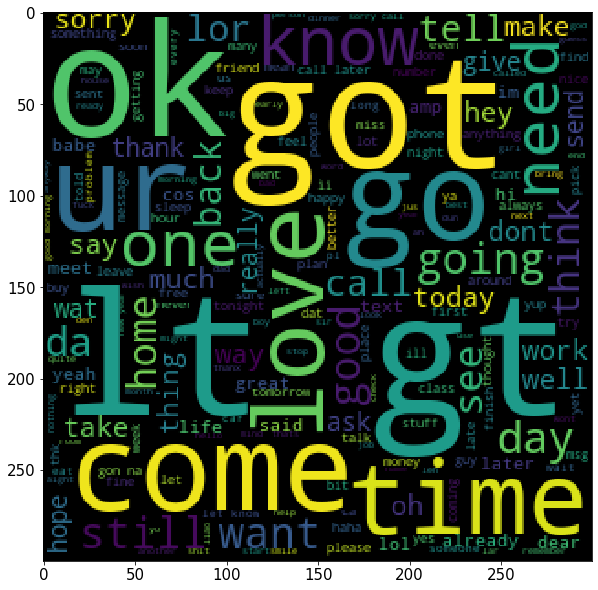

In [33]:
from wordcloud import WordCloud

# Ham wordcloud
ham_wordcloud = WordCloud(width=300, height=300).generate(" ".join(ham_words))
plt.figure(figsize=(10,8))
plt.imshow(ham_wordcloud)
plt.tight_layout(pad=0)
plt.show()

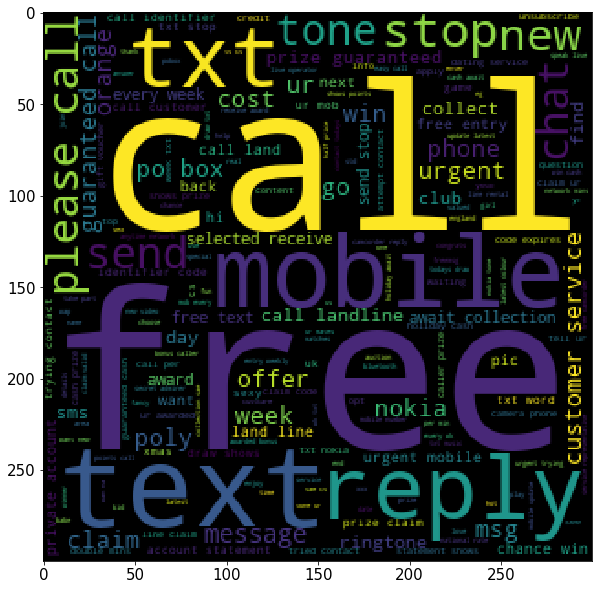

In [34]:
# Spam wordcloud
spam_wordcloud = WordCloud(width=300, height=300).generate(" ".join(spam_words))
plt.figure(figsize=(10,8))
plt.imshow(spam_wordcloud)
plt.tight_layout(pad=0)
plt.show()

In [35]:
# Part 2 - Preprocessing
# Some ideas about text preprocessing:
# - Lowercasing
# - Stemming or Lemmatization
# - Remove punctuation
# - Stopword Removal
# - Normalization (words like 'oki', 'ok', 'ok', ... to become just 'ok' or ;-) :-) :) just smile)
# - Noise Removal (stemming without noise removal could be bad)
# - Text enrichment / augmentation

# --------------------
# Bag of Words (BOW), consists of:
# - tokenizing
# - counting
# - normalizing

# We call vectorization the general process of turning a collection of text documents
# into numerical feature vectors. This specific strategy (tokenization, counting and normalization) 
# is called the Bag of Words or “Bag of n-grams” representation. Documents are described by
# word occurrences while completely ignoring the relative position information of the words in the document.

# Reference for more details:
# https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

In [36]:
# Punctuation
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [37]:
def remove_punctuation(sms):
    return sms.translate(str.maketrans('','',string.punctuation))

def remove_stopwords(sms):
    return [word.lower() for word in sms.split() if word.lower() not in stopwords.words("english")]

sms["message"].apply(lambda sms: remove_stopwords(remove_punctuation(sms))).head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, 2, wkly, comp, win, fa, cup, fin...
3        [u, dun, say, early, hor, u, c, already, say]
4    [nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

In [54]:
# CountVectorizer implements both tokenization and occurrence counting in a single class:
from sklearn.feature_extraction.text import CountVectorizer

bow_transformer = CountVectorizer(analyzer = lambda sms: remove_stopwords(remove_punctuation(sms))).fit(sms["message"])

In [50]:
print(len(bow_transformer.vocabulary_))

9431


In [51]:
# 9431 distinct words in all messages

In [71]:
test_spam = sms["message"][42]
bow_test_spam = bow_transformer.transform([test_spam])
print(test_spam)
print(bow_test_spam)

07732584351 - Rodger Burns - MSG = We tried to call you re your reply to our sms for a free nokia mobile + free camcorder. Please call now 08000930705 for delivery tomorrow
  (0, 29)	1
  (0, 53)	1
  (0, 1857)	1
  (0, 1906)	2
  (0, 1940)	1
  (0, 2684)	1
  (0, 3539)	2
  (0, 5470)	1
  (0, 5557)	1
  (0, 5789)	1
  (0, 6334)	1
  (0, 6879)	1
  (0, 6992)	1
  (0, 7521)	1
  (0, 8356)	1
  (0, 8453)	1


In [76]:
# let's see what words were used as tokens
rows, cols = bow_test_spam.nonzero()
for col in cols:
    print(bow_transformer.get_feature_names()[col])

07732584351
08000930705
burns
call
camcorder
delivery
free
mobile
msg
nokia
please
reply
rodger
sms
tomorrow
tried


In [80]:
bow_data = bow_transformer.transform(sms["message"])

In [83]:
print(type(bow_data))

<class 'scipy.sparse.csr.csr_matrix'>


In [81]:
bow_data.nnz

49772

In [82]:
bow_data.shape

(5572, 9431)

In [ ]:
# A collection of 10,000 short text documents (such as emails) will use a vocabulary
# with a size in the order of 100,000 unique words in total
# while each document will use 100 to 1000 unique words individually.
# In order to be able to store such a matrix in memory but also to speed up algebraic operations matrix / vector,
# implementations will typically use a sparse representation such as available in the scipy.sparse package.

In [88]:
# let's calculate the matrix sparsity = 1 - density (number of non-zero elements divided by the matrix size)
print( 1 - bow_data.nnz / (bow_data.shape[0] * bow_data.shape[1]) * 100 )

# 90% of the elements are zeros, the other 10% are ones.

0.9052855504022377
